In [18]:
import imp 

import os
import sys

import networkx as nx
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString,Point
import numpy as np


import matplotlib.pyplot as plt
import bokeh as bh

from datetime import datetime

%load_ext autoreload
%autoreload 2
import taxi_driver.taxi_driver as td

import plotly.express as px

import sklearn.metrics as skm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
#setting some much needed paths 

dataPath = os.path.join("data")
csvPath  = os.path.join(dataPath,"CSV")
shpPath  = os.path.join(dataPath,"SHP")

outputPath = os.path.join("outputs")
imagePath = os.path.join(outputPath,"images")



In [4]:
zoneShpPath = os.path.join(shpPath,"taxi_zones.shp")

#combine in one
# march_path = os.path.join(csvPath,"march_data.csv")
# june_path = os.path.join(csvPath,"june_data.csv")
# nov_path = os.path.join(csvPath,"november_data.csv")

# taxi_df=td.Taxidf([march_path,june_path,nov_path],sample_fraction=0.2,taxi_zones_shp_path=zoneShpPath)
#taxi_df.convert_dates()

#save the combined sample df
# csv_sample_path = os.path.join(csvPath,"sample_csv.csv")
# taxi_df.taxi_data.to_csv(csv_sample_path)
#---------------------------------------------------

#load the sample
csv_sample_path = os.path.join(csvPath,"sample_csv.csv")
taxi_df=td.Taxidf(csv_sample_path,taxi_zones_shp_path=zoneShpPath)
taxi_df.convert_dates()

In [5]:
#remove the abnormal dates
taxi_df.taxi_data=taxi_df.taxi_data.loc[taxi_df.taxi_data['pu_month'].isin([3,6,11])]


#will remove the day of the storm 
remove_dates=["2017-03-14","2017-06-25","2017-11-23","2017-11-24","2017-11-25","2017-11-26"]

for rd in remove_dates:
    sample_df = taxi_df.taxi_data[taxi_df.taxi_data['pu_date']!=rd]
    sample_df = sample_df[sample_df['do_date']!=rd]
    taxi_df.taxi_data = sample_df

In [37]:
sample_df=taxi_df.taxi_data.copy()

#will keep only the payment checks
clean_df = sample_df[sample_df['payment_type']==1]

# I will create a sample of only the non_negative
clean_df= clean_df[clean_df['tip_amount']>=0]
clean_df= clean_df[clean_df['trip_distance']>=0]

#controlling the value between >0 and 2000$
clean_df=clean_df.loc[(clean_df['fare_amount']>0) & (clean_df['fare_amount']<2000)]


Introduce some new features that might help on the modelling

In [7]:
import holidays
us_holidays = holidays.UnitedStates()
grouped_date=taxi_df.grouped_date()
holidays=[datetime.strptime(i,"%Y-%m-%d") in grouped_date for i in list (grouped_date.index)] 

if(not True in holidays):
    print("there are no holidays in the data set")
else:
    print("check for the holidays")

there are no holidays in the data set


In [38]:
clean_df['dollar_per_mile']=clean_df['fare_amount']/clean_df['trip_distance']
clean_df['tip_to_fare']=clean_df['tip_amount']/clean_df['fare_amount']
clean_df['duration_s']=(clean_df['tpep_dropoff_datetime']-clean_df['tpep_pickup_datetime']).apply(lambda x:x.seconds)

In [39]:
clean_df=clean_df[clean_df['tip_to_fare']<1]

In [40]:

corr = clean_df[["tip_amount",'passenger_count',"trip_distance","fare_amount","duration_s"]].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,tip_amount,trip_distance,fare_amount,duration_s
tip_amount,1.00,0.78,0.81,0.16
trip_distance,0.78,1.00,0.90,0.19
fare_amount,0.81,0.90,1.00,0.20
duration_s,0.16,0.19,0.20,1.00


My first intuition looking the highly correlated values of tip amount and fare_amount,trip_distance is to try to fit a linear model on the data and see how it behaves. So first we will create a simple linear regression model that will be our base model. Did a test with fare amount and trip duration but the coefficient for the trip duration was extremly low. 

In [293]:


data_train, data_test, labels_train, labels_test = train_test_split(clean_df[['fare_amount']],
                                                                    clean_df['tip_amount'], test_size=0.20, random_state=42)


reg_bm = LinearRegression().fit(data_train, labels_train)


labels_pred = reg_bm.predict(data_test)

# The coefficients
print('Coefficients: \n', reg_bm.coef_)
# The mean squared error

print('Mean squared error: %.2f'% skm.mean_squared_error(labels_test, labels_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'% skm.r2_score(labels_test, labels_pred))


Coefficients: 
 [0.17937802]
Mean squared error: 2.28
Coefficient of determination: 0.66


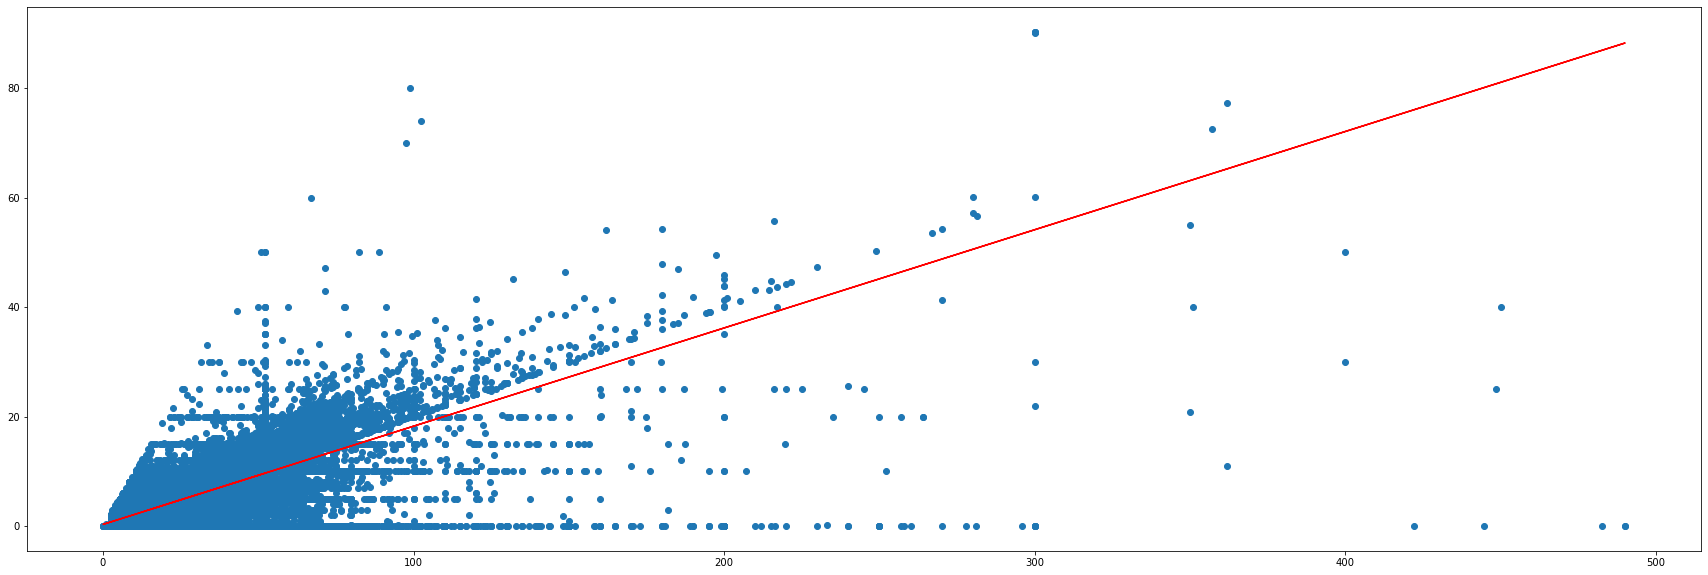

In [294]:
fig, ax =plt.subplots(figsize=(30,10))

ax.scatter(data_test['fare_amount'],list(labels_test))
ax.plot(data_test['fare_amount'], reg_bm.coef_*data_test['fare_amount'] + reg_bm.intercept_,color="red")


In [213]:
labels_zip=list(zip(list(labels_test),list(labels_pred)))
sorted_labels_zip=sorted(labels_zip,key=lambda x:x[1])

labels_test_ordered,labels_test_pred = zip(*sorted_labels_zip)


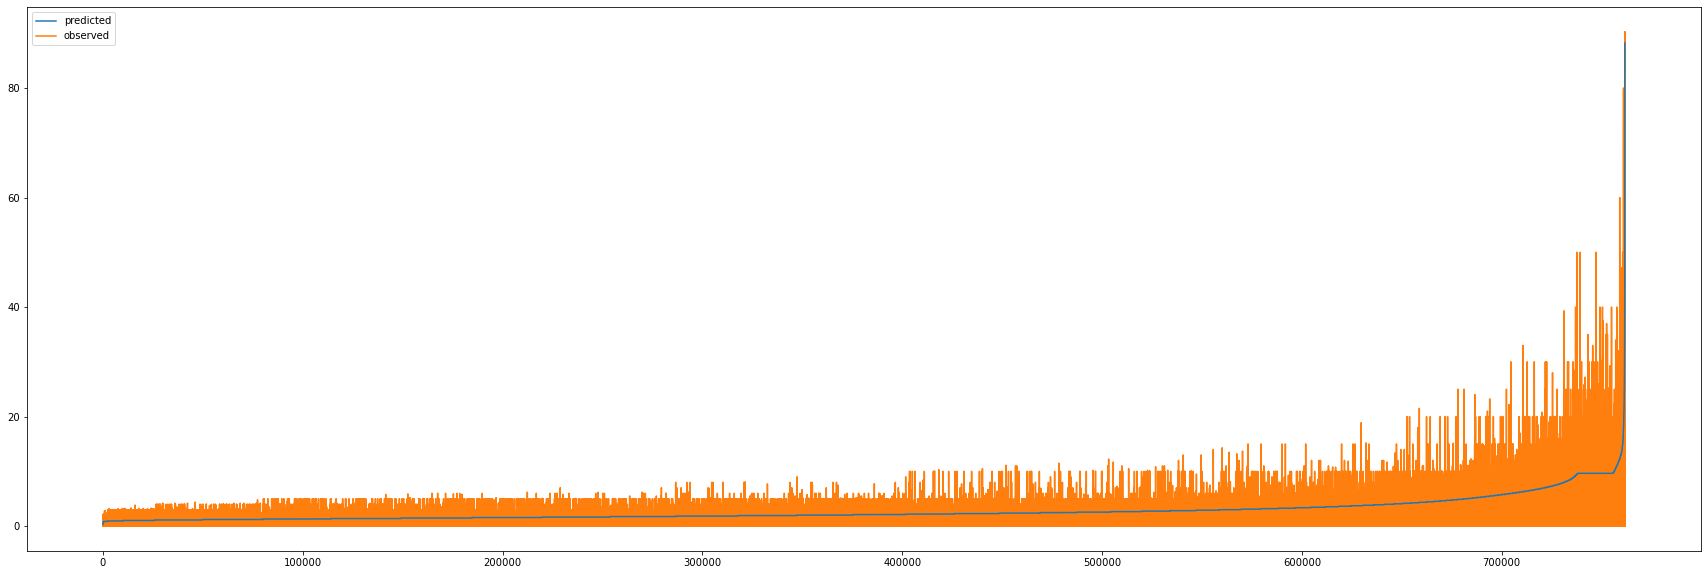

In [221]:
fig,ax = plt.subplots(figsize=(30,10))
ax.plot(labels_test_pred,zorder=100,label="predicted")
ax.plot(labels_test_ordered,label="observed")

plt.legend()

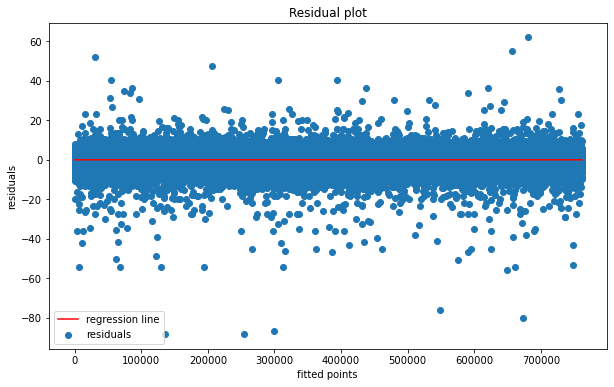

In [92]:

plt.figure(figsize=(10, 6))

f=np.arange(len(residuals))
k = [0 for i in range(len(residuals))]
plt.scatter( f, residuals, label = 'residuals')
plt.plot( f, k , color = 'red', label = 'regression line' )
plt.xlabel('fitted points ')
plt.ylabel('residuals')
plt.title('Residual plot')
plt.legend()




wanted to try also with the duration and the trip distance but this didn't perform aswell as the first

Then I decided to have a take on a spatial approach where I am going to build a model for each of the OD tupples

In [100]:
od_tip_data=clean_df.groupby(["PULocationID","DOLocationID"])['tip_amount'].agg(['mean', 'min', 'max',"count","std"])
od_tip_data.sort_values("count",ascending=False)

mean   min     max  count       std
PULocationID DOLocationID                                         
264          264           2.672992  0.00  100.00  50143  2.552504
237          236           1.443065  0.00   15.84  21309  0.588836
236          237           1.623669  0.00   15.00  17436  0.704971
             236           1.263850  0.00   20.00  16708  0.875903
237          237           1.335761  0.00   25.00  14053  0.953291
...                             ...   ...     ...    ...       ...
163          175           8.050000  8.05    8.05      1       NaN
19           191           1.100000  1.10    1.10      1       NaN
             218           0.000000  0.00    0.00      1       NaN
             219           3.570000  3.57    3.57      1       NaN
157          223           2.450000  2.45    2.45      1       NaN

[19926 rows x 5 columns]

In [258]:
od_tip_data.describe()

,mean,min,max,count,std
count,19926.000000,19926.000000,19926.000000,19926.000000,15148.000000
mean,5.010852,2.387441,8.821541,191.118388,2.379008
std,3.749922,3.954567,6.793341,785.297287,2.028844
min,0.000000,0.000000,0.000000,1.000000,0.000000
25%,2.533397,0.000000,5.000000,2.000000,1.177630
50%,4.202973,0.000000,8.000000,6.000000,1.870072
75%,6.513083,3.700000,11.040000,44.000000,3.012275
max,50.160000,48.580000,150.000000,50143.000000,52.081629


In [164]:
data_train['fare_amount'].mean()

7.949392712550607

In [254]:
modeling_sample=od_tip_data[od_tip_data['count']>1000]

In [256]:
fileName = "clean_sample.csv"
filePath = os.path.join(csvPath,fileName)
clean_df.to_csv(filePath)

In [259]:
r2_scores=[]
mse_scores=[]

linear_regression_performance = {}
index_=0
for tupple_ in modeling_sample.index:
    
    
    zone_tupple_df=clean_df[(clean_df['PULocationID']==tupple_[0]) & (clean_df['DOLocationID']==tupple_[1])]

    count_ = len(zone_tupple_df)


    data_train, data_test, labels_train, labels_test = train_test_split(zone_tupple_df[['fare_amount']],
                                                            zone_tupple_df['tip_amount'], test_size=0.20, random_state=42)


    reg = LinearRegression().fit(data_train, labels_train)
    labels_pred = reg.predict(data_test)
    mse_score=skm.mean_squared_error(labels_test, labels_pred)
    r2_score_ = skm.r2_score(labels_test, labels_pred)


    #i will also test if the tupple performs better using the bm 
    labels_pred_bm = reg_bm.predict(data_test)
    mse_score_bm=skm.mean_squared_error(labels_test, labels_pred_bm)
    r2_score_bm = skm.r2_score(labels_test, labels_pred_bm) 

    mean_trained = data_train['fare_amount'].mean()
    mean_vals = [ mean_trained for i in range(len(labels_pred_bm))]
    mse_score_mean=skm.mean_squared_error(mean_vals, labels_pred_bm)
    r2_score_mean = skm.r2_score(mean_vals, labels_pred_bm) 


    linear_regression_performance[tupple_]={"mse_score":mse_score,"r2_score":r2_score_,
                                            "local_coef":reg.coef_,"local_intercept":reg.intercept_,
                                            "mse_score_bm":mse_score_bm,"r2_score_bm":r2_score_bm,
                                             "mse_score_mean":mse_score_mean,"r2_score_mean":r2_score_mean}



    
    if(index_%100==0):
        
        print(len(modeling_sample.index)-index_, "left to go..")
        
        
    index_+=1


1035 left to go..
935 left to go..
835 left to go..
735 left to go..
635 left to go..
535 left to go..
435 left to go..
335 left to go..
235 left to go..
135 left to go..
35 left to go..


In [223]:
linear_regression_performance

{(13, 231): {'mse_score': 0.31942772295094657,
  'r2_score': 0.1833545509653982,
  'local_coef': array([0.14904572]),
  'local_intercept': 0.47696447281351506,
  'mse_score_bm': 0.31999502590380513,
  'r2_score_bm': 0.18190419039432482,
  'mse_score_mean': 23.519746229664353,
  'r2_score_mean': -2.9814820425249652e+31},
 (48, 48): {'mse_score': 1.9125597356050834,
  'r2_score': 0.7344872390786159,
  'local_coef': array([0.14900978]),
  'local_intercept': 0.49634280703592326,
  'mse_score_bm': 1.5603736971184654,
  'r2_score_bm': 0.7833797707448034,
  'mse_score_mean': 35.541952234399396,
  'r2_score_mean': -4.505477708321945e+31},
 (48, 68): {'mse_score': 0.3519861792831687,
  'r2_score': 0.3113358334601737,
  'local_coef': array([0.1384638]),
  'local_intercept': 0.5910008059741496,
  'mse_score_bm': 0.3460071086311735,
  'r2_score_bm': 0.32303393966316307,
  'mse_score_mean': 30.533676581457158,
  'r2_score_mean': 0.0},
 (48, 142): {'mse_score': 0.3642431990698548,
  'r2_score': 0.32

In [263]:
r2_scores_,mse_scores_,results_=[],[],[]
edge_list_local = []
edge_list_bm =[]
for keys,val in linear_regression_performance.items():
    
    mse_diff=val['mse_score']-val["mse_score_bm"]
    r2_diff = val['r2_score']-val['r2_score_bm']
    
    better_model="mix"
    if((mse_diff<0) and (r2_diff>0)):
        better_model = "local"
        edge_list_local.append(keys)
    elif((mse_diff>0) and (r2_diff<0)):
        better_model="bm"
        edge_list_bm.append(keys)

        
    linear_regression_performance[keys]['better_model']=better_model
    mse_scores_.append(mse_diff)
    r2_scores_.append(r2_diff)
    results_.append(better_model)

In [264]:
pd.Series(results_).value_counts()

local    686
bm       349
dtype: int64

In [230]:
od_tip_data

mean    min     max  count        std
PULocationID DOLocationID                                            
1            1             12.617061   0.00   49.54    279  10.262015
             7             17.250000  17.25   17.25      1        NaN
             21            12.000000  12.00   12.00      1        NaN
             65            11.000000  11.00   11.00      1        NaN
             87             5.000000   5.00    5.00      1        NaN
...                              ...    ...     ...    ...        ...
265          259           20.000000  20.00   20.00      1        NaN
             262            1.960000   1.96    1.96      1        NaN
             263            0.770000   0.00    1.36      3   0.697639
             264            8.333333   0.00   20.00      3  10.408330
             265           11.090422   0.00  150.00   1681  12.807538

[19926 rows x 5 columns]

In [265]:
taxi_df.compute_taxi_zones()
taxi_df.graph_representation()
taxi_df.assign_attributes_to_graph(od_tip_data,["mean","min","max","count","std"])



In [268]:
clear_bm_edgelist =[]
for i in edge_list_bm:
    if(i in list(taxi_df.G_main.edges())):
        clear_bm_edgelist.append(i)
        
clear_local_edgelist =[]
for i in edge_list_local:
    if(i in list(taxi_df.G_main.edges())):
        clear_local_edgelist.append(i)

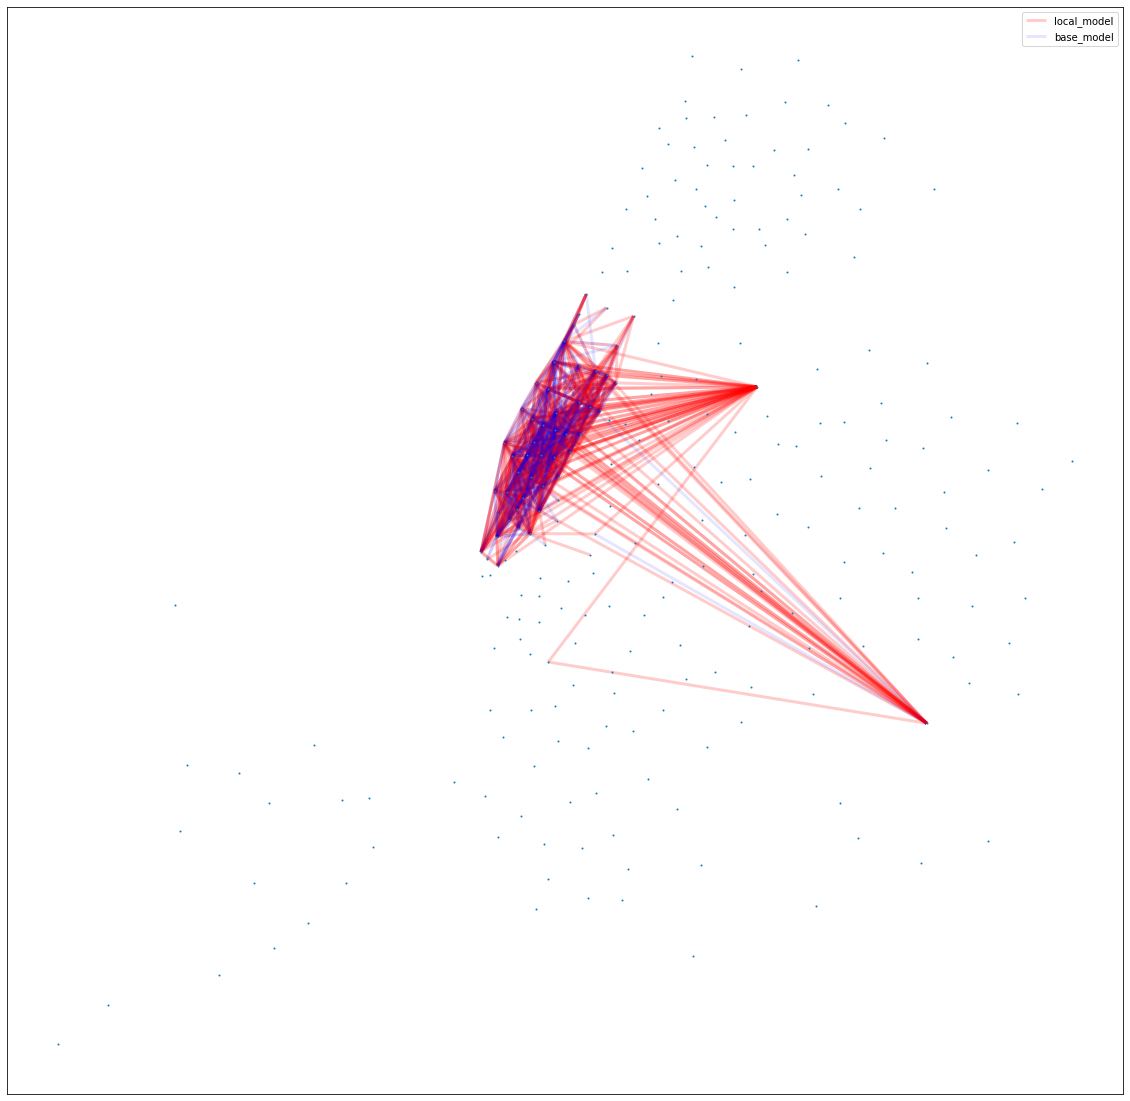

In [274]:
#most of the trips sampled with higher than 7dollar per mile existin in the manhattan area

min_vals=np.array(list(nx.get_edge_attributes(taxi_df.G_main,"std").values()))

        
fig,ax = plt.subplots(figsize=(20,20))
nx.draw_networkx_nodes(taxi_df.G_main,pos=taxi_df.pos,node_size=1,ax=ax)
nx.draw_networkx_edges(taxi_df.G_main,pos=taxi_df.pos,arrows=False,ax=ax,width=3,alpha=0.2,
                       edge_color="red",edgelist=clear_local_edgelist,label="local_model")


nx.draw_networkx_edges(taxi_df.G_main,pos=taxi_df.pos,arrows=False,ax=ax,width=3,alpha=0.1,
                       edge_color="blue",edgelist=clear_bm_edgelist,label="base_model")

plt.legend()

Text(0.5, 1.0, 'R2 scores comparisson')

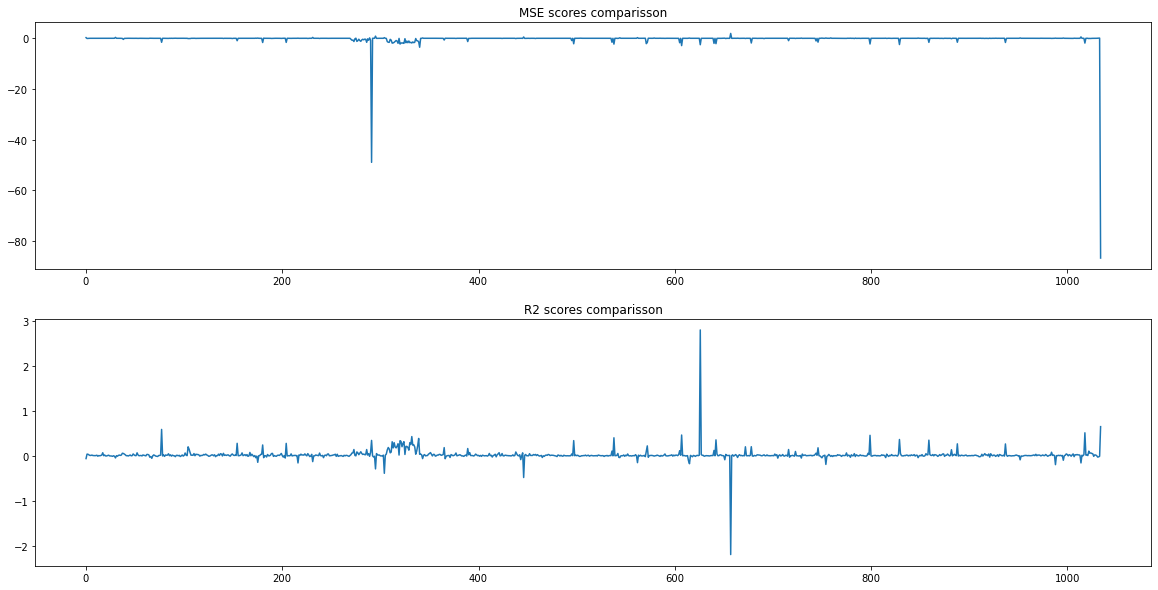

In [275]:
fig,ax = plt.subplots(2,1,figsize=(20,10))

ax[0].plot(mse_scores_)
ax[0].set_title("MSE scores comparisson")

ax[1].plot(r2_scores_)
ax[1].set_title("R2 scores comparisson")


In [277]:
pd.DataFrame(linear_regression_performance).T

mse_score   r2_score             local_coef local_intercept  \
13  13    1.93745    0.50452  [0.19406284930280876]        0.254342   
    48      1.881   0.121045   [0.1672773533908427]        0.425612   
    68    1.07316   0.069297  [0.14283430617797913]        0.728692   
    87   0.359863   0.103978  [0.14437669162860342]        0.605035   
    158  0.336344   0.209993   [0.1725334985136356]        0.360634   
...           ...        ...                    ...             ...   
263 239  0.464276   0.215051  [0.18262614225002355]        0.203414   
    262  0.336036   0.514304  [0.15168565081672844]        0.450482   
    263  0.460479   0.696628  [0.21009585314524812]        0.154653   
264 264   2.45466   0.605958  [0.14415123303257613]        0.741864   
265 265   121.418  0.0951921  [0.09589797549778027]         2.21819   

        mse_score_bm r2_score_bm mse_score_mean r2_score_mean better_model  
13  13        1.6872    0.568519        44.4808  -1.40965e+31           bm  
    48       1.95554   0.0862133        217.195   -1.7208e+31        local  
    68       1.11013    0.037235        99.4879   -3.1529e+31        local  
    87      0.366662   0.0870501         39.091             0        local  
    158     0.338737    0.204371        47.5486             0        local  
...              ...         ...            ...           ...          ...  
263 239     0.464951     0.21391        59.8099  -1.89545e+31        local  
    262     0.314977    0.544741        15.1373  -1.91888e+31           bm  
    263     0.421103     0.72257          18.11  -2.29572e+31           bm  
264 264      2.37817    0.618236        119.023    -3.772e+31           bm  
265 265      208.055   -0.550425        5919.57             0        local  

[1035 rows x 9 columns]

In [280]:
resultDf=pd.DataFrame(linear_regression_performance).T.reset_index()
resultDf.to_csv("results.csv")

In [291]:
print("Mean MSE", resultDf['mse_score'].mean(), "Mean R2",resultDf['r2_score'].mean())

Mean MSE 1.6135879592365598 Mean R2 0.24279606368026097


In [292]:
resultDf['local_intercept'].mean()

0.5770236552610628

In [319]:

def local_model_fit(x,attr,bm_model,local_dict):
    
    predictions=[]
    
    for row_ in range(len(x)):

        od_tupple = (x.iloc[row_]["PULocationID"],x.iloc[row_]["DOLocationID"])
        
        if(od_tupple in list(local_dict.keys())):
            if(local_dict[od_tupple]=="local"):
                
                pred_label = x.iloc[row_][attr]*local_dict[od_tupple]['local_coef']+local_dict[od_tupple]["local_intercept"]
                
            else:
                pred_label = bm_model.predict(np.array(x.iloc[row_][attr]).reshape(-1,1))
            
        else:
            pred_label = bm_model.predict(np.array(x.iloc[row_][attr]).reshape(-1,1))
            
        
        predictions.append(pred_label)
        
    return predictions

test the local model

In [336]:

data_train, data_test, labels_train, labels_test = train_test_split(clean_df[['fare_amount',"duration_s","dollar_per_mile","PULocationID","DOLocationID"]],
                                                                    clean_df['tip_amount'], test_size=0.20, random_state=105)




In [318]:
reg.predict(np.array(0).reshape(1,-1))

array([2.21819075])

In [321]:
pred_labels=local_model_fit(data_test,"fare_amount",reg_bm,linear_regression_performance)

In [322]:
print('Mean squared error: %.2f'% skm.mean_squared_error(labels_test, pred_labels))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'% skm.r2_score(labels_test, pred_labels))

Mean squared error: 2.25
Coefficient of determination: 0.66


trying to imporve the model predictions with rf

In [334]:
from sklearn.ensemble import RandomForestRegressor

regressor_rf = RandomForestRegressor(n_jobs=-1)
regressor_rf.fit(np.array(data_train['fare_amount'].values).reshape(-1,1),labels_train.values)


RandomForestRegressor(n_jobs=-1)

array([[1.10000000e+01, 7.64000000e+02, 4.40000000e+00],
       [1.95000000e+01, 1.93300000e+03, 9.28571429e+00],
       [5.20000000e+01, 4.46400000e+03, 2.54652302e+00],
       ...,
       [6.50000000e+00, 3.71000000e+02, 5.32786885e+00],
       [1.20000000e+01, 9.75000000e+02, 5.26315789e+00],
       [1.30000000e+01, 1.26500000e+03, 1.18181818e+01]])

In [335]:
y_pred_rfraw = regressor_rf.predict(np.array(data_test['fare_amount'].values).reshape(-1,1))

print('RMSE score for the RF regressor is : {}'.format(np.sqrt(skm.mean_squared_error(labels_test,y_pred_rfraw))))
print('Variance score for the RF regressor is : %.2f' % regressor_rf.score(np.array(data_test['fare_amount'].values).reshape(-1,1), labels_test))

RMSE score for the RF regressor raw is : 1.463827496636688
Variance score for the RF regressor is : 0.68


[2.36,
 4.25,
 11.71,
 2.0,
 5.34,
 2.45,
 2.0,
 2.46,
 2.56,
 1.28,
 3.85,
 2.56,
 4.86,
 1.35,
 1.0,
 1.26,
 2.64,
 1.25,
 0.0,
 2.5,
 1.66,
 6.6,
 2.16,
 1.0,
 2.55,
 2.75,
 1.32,
 0.75,
 1.2,
 1.86,
 0.0,
 1.0,
 1.7,
 2.32,
 1.45,
 4.2,
 1.0,
 1.85,
 2.15,
 3.36,
 2.06,
 3.0,
 1.0,
 11.02,
 1.7,
 2.26,
 1.06,
 1.0,
 1.0,
 2.26,
 0.0,
 2.85,
 3.06,
 2.55,
 9.0,
 1.36,
 1.0,
 0.0,
 1.0,
 2.0,
 1.7,
 2.36,
 4.3,
 2.9,
 2.06,
 3.7,
 3.8,
 10.55,
 0.75,
 1.0,
 9.31,
 3.08,
 4.46,
 7.01,
 1.7,
 6.36,
 0.0,
 8.76,
 0.95,
 1.0,
 1.66,
 4.45,
 5.95,
 1.0,
 3.0,
 5.0,
 1.86,
 1.06,
 1.56,
 1.58,
 5.76,
 3.86,
 2.6,
 2.25,
 2.7,
 4.01,
 2.2,
 2.66,
 2.35,
 2.25,
 2.95,
 3.85,
 5.0,
 17.5,
 7.96,
 1.35,
 1.82,
 2.16,
 2.0,
 3.45,
 0.8,
 2.96,
 5.0,
 16.07,
 1.2,
 5.95,
 11.71,
 1.59,
 5.75,
 1.0,
 2.45,
 4.45,
 3.45,
 1.0,
 2.76,
 5.0,
 4.96,
 1.77,
 2.2,
 2.8,
 14.64,
 1.36,
 1.0,
 4.06,
 4.32,
 1.06,
 2.0,
 1.0,
 3.25,
 2.95,
 1.2,
 1.32,
 1.55,
 2.0,
 5.0,
 2.56,
 2.66,
 1.7,
 3.05,
 0.5,
 

In [ ]:
regressor_rf_1 = RandomForestRegressor(n_jobs=-1)
regressor_rf_1.fit(np.array(data_train[["fare_amount","duration_s"]].values),labels_train.values)


y_pred_rfraw = regressor_rf.predict(np.array(data_test[["fare_amount","duration_s"]].values).reshape(-1,1))

print('RMSE score for the RF regressor is : {}'.format(np.sqrt(skm.mean_squared_error(list(labels_test),y_pred_rfraw))))
print('Variance score for the RF regressor is : %.2f' % regressor_rf_1.score(np.array(data_test['fare_amount'].values).reshape(-1,1), labels_test))